# Performance Hints

How to run `Exponax` even faster than it already is 😉.

This is beyond some general insights:

* Whenever the `exponax.rollout` or `exponax.repeat` function transformations
    are used, they internally perform a `jax.jit` over the timestepper. Hence,
    there is no need to wrap the resulting function in a `jax.jit` again.
    However, when using the timesteppers directly, it can be advantageous to
    Just-In-Time compile them.
* The number of total degrees of freedom scale exponentially with the number of
    dimensions; so does the cost of the spatial FFT and hence the cost of
    simulation. As a good guideline on a modern GPU:
    * 1d: Highest still nice `num_points` is between 10'000 to 100'000. For most
        problems, 50-500 points are likely sufficient.
    * 2d: Highest still nice `num_points` is around 500 (-> 25k total DoF per
        channel). For most problems, 50-256 points are likely sufficient.
    * 3d: Highest still nice `num_points` is around 48 (-> 110k total DoF per
        channel). In general, 3d sims will be tough.
* The produced trajectory array is as large as the number of time steps
    performed. Hence, if the underlying discretization already has a lot of
    total DoF, the trajectory array can become quite large. If you are only
    interested in every n-th step, consider wrapping the time stepper in a
    `RepeatedStepper`
* Some usages of `jax.vmap` only work efficiently on GPUs & TPUs, on CPUs JAX
    resorts to sequential looping.

In [18]:
import jax
import jax.numpy as jnp
import exponax as ex
import equinox as eqx

## Temporal Rollout in Fourier space

The methods of `Exponax` advance a state to the next time step in Fourier space.
If the stepper is called with a state in physical space, it is first transformed
to Fourier space, then advanced, and finally transformed back to physical space.
This is done for each time step. We can also integrate it directly in Fourier
space and then backtransform the entire trajectory.

This especially saves compute for lower orders of EDTRK integrators (in the
greatest sense for linear PDEs) that perform fewer FFTs per time step.

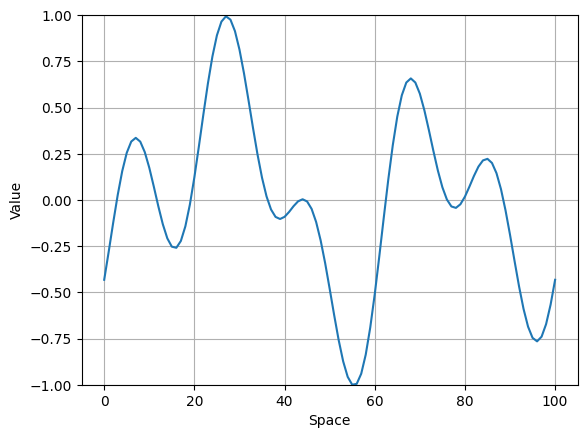

In [3]:
NUM_SPATIAL_DIMS = 1
DOMAIN_EXTENT = 3.0
NUM_POINTS = 100
DT = 0.1

burgers_stepper = ex.stepper.Burgers(NUM_SPATIAL_DIMS, DOMAIN_EXTENT, NUM_POINTS, DT)

u_0 = ex.ic.RandomTruncatedFourierSeries(
    NUM_SPATIAL_DIMS,
    cutoff=5,
    max_one=True,
)(NUM_POINTS, key=jax.random.PRNGKey(0))

ex.viz.plot_state_1d(u_0)

The state of the initial condition is a 1x100 tensor with **real** floating
point values

In [4]:
u_0.shape, u_0.dtype

((1, 100), dtype('float32'))

For an integration in Fourier space, we have to transform it to Fourier space.
Important, whenever we are dealing with FFTs in `Exponax`, we need to use
`rfft`.

In [5]:
u_0_hat = jnp.fft.rfft(u_0)

Its shape is `(1, 51)`, and has complex values. (JAX' `complex64` type is composed of two `float32` values)

In [6]:
u_0_hat.shape, u_0_hat.dtype

((1, 51), dtype('complex64'))

We can use the familiar `ex.rollout` function transformation but need to
transform the step function in Fourier space.

In [7]:
trj_hat = ex.rollout(burgers_stepper.step_fourier, 100, include_init=True)(u_0_hat)

Using a `jnp.fft.irfft` will batch over all time steps. (We need to inform the
number of points because we used the real-valued FFT)

In [8]:
trj = jnp.fft.irfft(trj_hat, n=NUM_POINTS)

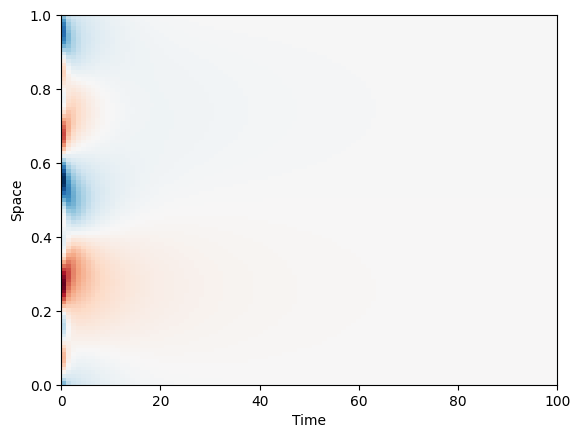

In [9]:
ex.viz.plot_spatio_temporal(trj)

The trajectory is identical to the one obtained by simulation in physical space

In [13]:
jnp.allclose(
    trj,
    ex.rollout(burgers_stepper, 100, include_init=True)(u_0),
    atol=1e-5,
)

Array(True, dtype=bool)

## Ensemble simulation

One particular feature of `Exponax` that is highly relevant for the integration
with deep learning is the batched execution.

Rather straightforward, we can `jax.vmap` a timestepper to operate in muliple
states at once.

In [14]:
NUM_SPATIAL_DIMS = 1
DOMAIN_EXTENT = 3.0
NUM_POINTS = 100
DT = 0.1

burgers_stepper = ex.stepper.Burgers(NUM_SPATIAL_DIMS, DOMAIN_EXTENT, NUM_POINTS, DT)

ic_gen = ex.ic.RandomTruncatedFourierSeries(
    NUM_SPATIAL_DIMS,
    cutoff=5,
    max_one=True,
)

one_u_0 = ic_gen(NUM_POINTS, key=jax.random.PRNGKey(0))

multiple_u_0 = ex.build_ic_set(
    ic_gen, num_points=NUM_POINTS, num_samples=10, key=jax.random.PRNGKey(0)
)

In [15]:
one_u_0.shape, multiple_u_0.shape

((1, 100), (10, 1, 100))

In [16]:
one_u_1 = burgers_stepper(one_u_0)
# burgers_stepper(mutliple_u_0)  # This will fail because the vanilla timestepper is single-batch only
multiple_u_1 = jax.vmap(burgers_stepper)(multiple_u_0)

In [17]:
one_u_1.shape, multiple_u_1.shape

((1, 100), (10, 1, 100))

When using `jax.vmap`, we essentially share the same dynamics across all initial
states. What if we wanted to simulate the same state but with three different
dynamics? We could create a list of timesteppers and then loop over time (for
example, with a list comprehension). However, sequential looping is slow. There
is an easy way to also use JAX' automatic vectorization for that. For this we
create an ensemble of three different Burgers steppers (this will only work if
the parameter we vmap over does not change the shape the timesteppers attribute
arrays).

In [19]:
DIFFUSIVITIES = jnp.array([0.1, 0.3, 0.7])

burgers_stepper_ensemble = eqx.filter_vmap(
    lambda nu: ex.stepper.Burgers(
        NUM_SPATIAL_DIMS, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=nu
    )
)(DIFFUSIVITIES)

If we inspect the single timestepper PyTree structure next to the ensemble
timestepper PyTree structure, we see an additional batch axis in the internal
arrays.

In [20]:
burgers_stepper, burgers_stepper_ensemble

(Burgers(
   num_spatial_dims=1,
   domain_extent=3.0,
   num_points=100,
   num_channels=1,
   dt=0.1,
   dx=0.03,
   _integrator=ETDRK2(
     dt=0.1,
     _exp_term=c64[1,51],
     _nonlinear_fun=ConvectionNonlinearFun(
       num_spatial_dims=1,
       num_points=100,
       dealiasing_mask=bool[1,51],
       derivative_operator=c64[1,51],
       scale=1.0,
       single_channel=False
     ),
     _coef_1=f32[1,51],
     _coef_2=f32[1,51]
   ),
   diffusivity=0.1,
   convection_scale=1.0,
   dealiasing_fraction=0.6666666666666666,
   single_channel=False
 ),
 Burgers(
   num_spatial_dims=1,
   domain_extent=3.0,
   num_points=100,
   num_channels=1,
   dt=0.1,
   dx=0.03,
   _integrator=ETDRK2(
     dt=0.1,
     _exp_term=c64[3,1,51],
     _nonlinear_fun=ConvectionNonlinearFun(
       num_spatial_dims=1,
       num_points=100,
       dealiasing_mask=bool[3,1,51],
       derivative_operator=c64[3,1,51],
       scale=1.0,
       single_channel=False
     ),
     _coef_1=f32[3,1,51],
 

First task is to make three different predictions from the single initial
condition.

In [21]:
ensembled_u_1 = eqx.filter_vmap(lambda stepper: stepper(one_u_0))(
    burgers_stepper_ensemble
)

This adds a three-dimensional batch axis to the state

In [22]:
ensembled_u_1.shape

(3, 1, 100)

We can also use both vmapping over the ensemble and the multiple initial states

In [23]:
ensembled_multiple_u_1 = eqx.filter_vmap(
    lambda stepper: jax.vmap(stepper)(multiple_u_0)
)(burgers_stepper_ensemble)

In [24]:
ensembled_multiple_u_1.shape

(3, 10, 1, 100)

Be mindful about the order of nested vmappings as they affect the order of axes
in the returned arrays.